In [1]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

In [2]:
key = jax.random.PRNGKey(0)

In [3]:
def getLine(phi, theta, r_max = 10):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

## 1. Introduction

In this notebook, we try to demonstrate an LCAO Ansatz combined with a Neural Network to find the ground state of the $\mathrm{H}_2^{+}$ molecule.
The LCAO Ansatz enforces the Kato-cusp condition, which is difficult to model by a Neural Network (singularity of the gradient). The deviations from the LCAO Ansatz are represented by a Neural Network.

Given the nucliei positions $\vec{R_i} $, the potential Energy is:

$$
V = - \sum_{i} \frac{k_i}{|\vec{r} - \vec{R_i}|}
$$

with $k_i = \frac{Z_i e^2}{4 \pi \epsilon_0}$

The solution to the single-nucleus problem is known:

$$
\Phi_i = e^{-\frac{m}{\hbar^2}k_i |\vec{r} - \vec{R_i}|} 
$$

notably satisfying the cusp condition:

$$
Z_k = -\frac{a_0}{2 n} \frac{dn}{dr} \quad\text{for} \lim r \to 0
$$

with $n = |\Psi|^2$.

The resulting Ansatz is thus:

$$
\Psi = \sum_{i} \alpha_i \Phi_i(\vec{r}) + e^{NN(\vec{r})}
$$

and $NN$ is a $C^2$-smooth Neural Network.

Remark: $\hbar = m  = 1$ and $k = \sqrt{2}$ will be set.

### 1.1 Defining the Potential Energy

(-5.0, 1.0)

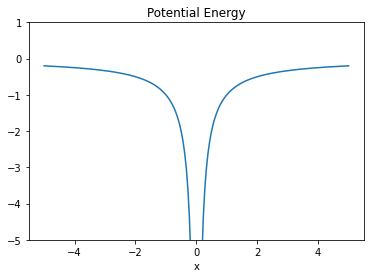

In [4]:
R = jnp.array([[0,0,0]])     # nuclei positions
k = jnp.array([1.])                          # potential energy coefficients

#
# The potential energy function depending on the coordinates
#
def potential(x):
    x = jnp.expand_dims(x, axis = 1)
    r = jnp.expand_dims(R,  axis = 0)
    d = jnp.sqrt(jnp.sum((x - r)**2, axis = 2))
    return - jnp.sum(k/d ,axis = 1)


# the hamiltonian
hamiltonian = module.hamiltonians.Particles(masses = [1], potential = potential)

xs = jnp.linspace(-5, 5, 200)
pos = jnp.array([xs,xs*0,xs*0])
ys = potential(jnp.swapaxes(pos, 0, 1))
plt.plot(xs, ys)
plt.title("Potential Energy")
plt.xlabel("x")
plt.ylim(-5, 1)

### 1.2 Defining the Wavefunction

In [6]:
class NN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(15, name="dense1", bias_init=jax.random.normal)(x)
        x = jnp.log(jnp.cosh(x))
        x = nn.Dense(15, name="dense2", bias_init=jax.random.normal)(x)
        x = jnp.log(jnp.cosh(x))
        x = nn.Dense(15, name="dense3", bias_init=jax.random.normal)(x)
        x = jnp.log(jnp.cosh(x))
        x = nn.Dense(1, name="dense4", bias_init=jax.random.normal)(x)
        x = jnp.log(jnp.cosh(x))
        return -jnp.squeeze(x)

In [7]:
class Ansatz(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__(input_shape = (3,))

        self.nn = NN()
        self.lcao = module.wavefunctions.LCAO(R, k)


    def init_param(self, key):
        nn_param = self.nn.init(key, jnp.empty((3,)))
        lcao_coeff = jnp.array([1.])

        return {"nn": nn_param,
                "lcao": lcao_coeff}
    
    def calc_logpsi(self, parameters, x):
        return self.lcao.calc_logpsi(jnp.exp(parameters["lcao"]), x) + self.nn.apply(parameters["nn"], x)

In [8]:
ansatz = Ansatz()
key, _ = jax.random.split(key)
param = ansatz.init_param(key)

Text(0.5, 0, 'x')

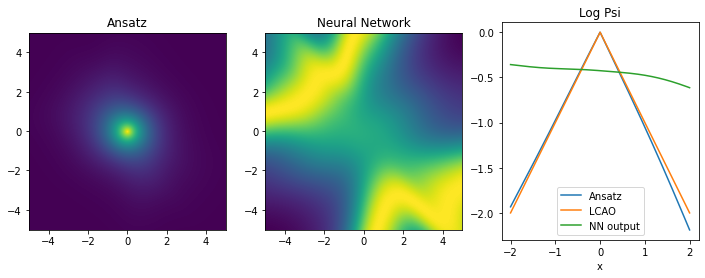

In [9]:
f, axs = plt.subplots(1, 3, figsize = (12,4))

xs = jnp.linspace(-5, 5, num = 1000)
ys = jnp.linspace(-5, 5, num = 1000)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0), axis = 2)

res = ansatz.calc_psi(param, im.reshape(-1, 3)).reshape(xss.shape)
axs[0].imshow(res, extent = [-5, 5, -5, 5])
axs[0].set_title("Ansatz")

res = ansatz.nn.apply(param["nn"], im.reshape(-1, 3)).reshape(xss.shape)
axs[1].imshow(jnp.exp(res), extent = [-5, 5, -5, 5])
axs[1].set_title("Neural Network")


r, line = getLine(0, jnp.pi/2, r_max=2)
psi = ansatz.calc_logpsi(param, line)
psi_lcao = ansatz.lcao.calc_logpsi(param["lcao"], line)
nn_out = ansatz.nn.apply(param["nn"], line)

axs[2].plot(r, psi - jnp.max(psi), label = "Ansatz")
axs[2].plot(r, psi_lcao - jnp.max(psi_lcao), label = "LCAO")
axs[2].plot(r, nn_out, label = "NN output")

axs[2].set_title("Log Psi")
axs[2].legend()
axs[2].set_xlabel("x")

### 1.3 Initialise Sampler

In [10]:
sampler = module.samplers.MCMC(ansatz, 0.5)

Acceptance Ratio: 0.5201
Expected Energy: -0.4818477
Std of Expected Energy: 0.0017481679


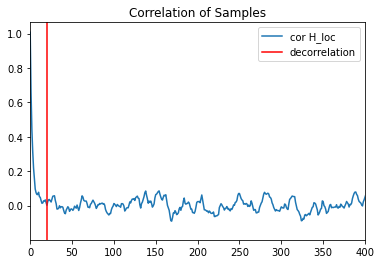

In [11]:
N = 10000
samples, ratio = sampler.sample(key, param, jax.random.normal(key, shape = (3,)), N)
H_loc = hamiltonian.calc_H_loc(ansatz, param, samples)
print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc)/jnp.sqrt(N))

plt.plot(jnp.correlate(H_loc-jnp.mean(H_loc), H_loc[0:2000]-jnp.mean(H_loc))/jnp.std(H_loc[0:2000])**2/2000, label = "cor H_loc")
plt.xlim(0,400)
plt.axvline(20, color = "r", label = "decorrelation")
plt.title("Correlation of Samples")
plt.legend()
plt.show()

In [12]:
subsampling = 20

In [13]:
def get_samples(N):
    """
    Returns decorrelated samples.
    """
    samples, ratio = sampler.sample(key, param, jax.random.normal(key, shape = (3,)), N*subsampling)
    return samples[0:-1:subsampling], ratio

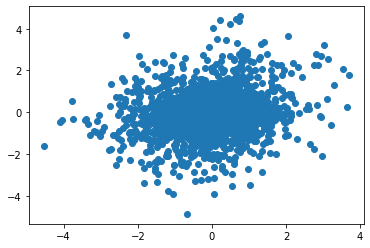

In [14]:
samples, ratio = get_samples(2000)
plt.scatter(samples[:, 0], samples[:, 1])

## 2. Energy Minimisation

In [15]:
@partial(jax.jit, static_argnames=['hamiltonian', 'orbital'])
def calc_grad_E(hamiltonian, orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = hamiltonian.calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc)
    dE = jnp.std(E_loc)
    grad_log = orbital.grad_logpsi(parameters, samples)

    m = lambda tree: 2*jnp.real(jnp.mean(jnp.swapaxes(jnp.swapaxes(tree, 0, -1) * (E_loc - E), 0, -1), axis = 0))

    return jax.tree_util.tree_map(m, grad_log), E, dE

In [16]:
stats = {"E":[], "dE":[], "ratio":[]}
param = ansatz.init_param(key)

In [17]:
N = 4000
epoch = 100

# define
optimizer = optax.adam(learning_rate=0.001)

# initialise
optimizer_state = optimizer.init(param)

for i in tqdm(range(epoch)):
    key, _ = jax.random.split(key)
    samples, ratio = get_samples(N)
    grad, E, dE = calc_grad_E(hamiltonian, ansatz, param, samples)

    stats["E"].append(E)
    stats["dE"].append(dE)
    stats["ratio"].append(ratio)
    
    updates, optimizer_state = optimizer.update(grad, optimizer_state, param)

    param = optax.apply_updates(param, updates)

100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


Text(0.5, 1.0, 'Acceptance Ratio')

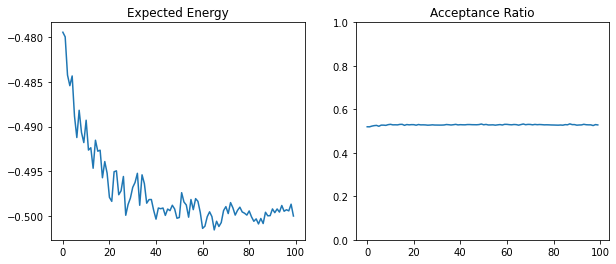

In [18]:
numpy_stats = {}
for key_ in stats.keys():
    numpy_stats[key_] = np.array(stats[key_])

f, ax = plt.subplots(1, 2, figsize = (10,4))
i = np.arange(len(stats["E"]))

ax[0].plot(i, numpy_stats["E"])
# ax[0].fill_between(i, numpy_stats["E"] - numpy_stats["dE"], numpy_stats["E"] + numpy_stats["dE"], alpha = 0.5)
ax[0].set_title("Expected Energy")

ax[1].plot(stats["ratio"])
ax[1].set_ylim(0,1)
ax[1].set_title("Acceptance Ratio")

Text(0.5, 1.0, 'Neural Network')

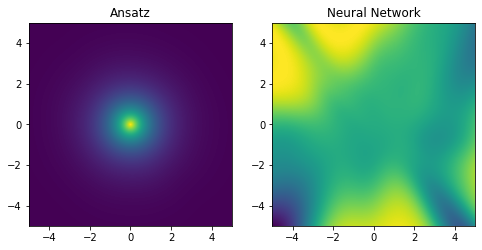

In [19]:
f, axs = plt.subplots(1, 2, figsize = (8,4))

xs = jnp.linspace(-5, 5, num = 1000)
ys = jnp.linspace(-5, 5, num = 1000)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0), axis = 2)

res = ansatz.calc_psi(param, im.reshape(-1, 3)).reshape(xss.shape)
axs[0].imshow(res, extent = [-5, 5, -5, 5])
axs[0].set_title("Ansatz")

res = ansatz.nn.apply(param["nn"], im.reshape(-1, 3)).reshape(xss.shape)
axs[1].imshow(jnp.exp(res), extent = [-5, 5, -5, 5])
axs[1].set_title("Neural Network")

Text(0.5, 0, 'x')

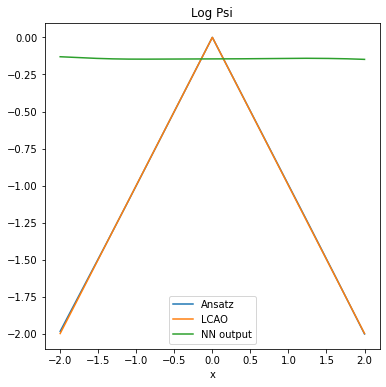

In [20]:
plt.figure(figsize=(6, 6))

r, line = getLine(0, jnp.pi/2, r_max=2)
psi = ansatz.calc_logpsi(param, line)
psi_lcao = ansatz.lcao.calc_logpsi(param["lcao"], line)
nn_out = ansatz.nn.apply(param["nn"], line)

plt.plot(r, psi - jnp.max(psi), label = "Ansatz")
plt.plot(r, psi_lcao - jnp.max(psi_lcao), label = "LCAO")
plt.plot(r, nn_out, label = "NN output")


plt.title("Log Psi")
plt.legend()
plt.xlabel("x")

In [21]:
N = 10000
samples, ratio = get_samples(N)
H_loc = hamiltonian.calc_H_loc(ansatz, param, samples)
print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc)/jnp.sqrt(N))

Acceptance Ratio: 0.527595
Expected Energy: -0.49981385
Std of Expected Energy: 0.0003090753
